In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
from scipy.stats import probplot
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import statsmodels.stats.api as sms
import statsmodels.stats.outliers_influence as oi
import scipy.stats as stats
from boruta import BorutaPy
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

# Import data files

All the data belongs to Kaggle

In [118]:
video_games_sales = pd.read_csv('video_games_sales.csv')

video_games_sales

,rank,name,platform,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
...,...,...,...,...,...,...,...,...,...,...,...
16593,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,Kemco,0.01,0.00,0.00,0.00,0.01
16594,16597,Men in Black II: Alien Escape,GC,2003.0,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01
16595,16598,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,Activision,0.00,0.00,0.00,0.00,0.01
16596,16599,Know How 2,DS,2010.0,Puzzle,7G//AMES,0.00,0.01,0.00,0.00,0.01


### Video Game Sales

- rank = Sales rank
- name = Name of video game
- platform = Video Game Platform
- year = When game was released
- genre = Game Genre
- publsher = Video Game Publisher
- na_sales = North America Sales, Millions
- eu_sales = European Sales, Millions
- jp_sales = Japan Sales, Millions
- other_sales = Sales in other areas, millions

In [119]:
data = video_games_sales.copy()


# Clean Data

#### Check for missing values

- If missing values found, impute or drop them based off data
- In this case, we will drop the missing values becuase you can not impute the year or publisher

In [120]:
data.isnull().sum()

rank              0
name              0
platform          0
year            271
genre             0
publisher        58
na_sales          0
eu_sales          0
jp_sales          0
other_sales       0
global_sales      0
dtype: int64

In [121]:
data = data.dropna()
data.isnull().sum()

rank            0
name            0
platform        0
year            0
genre           0
publisher       0
na_sales        0
eu_sales        0
jp_sales        0
other_sales     0
global_sales    0
dtype: int64

#### Check for duplicates

- If duplicates found, we drop them
- No duplicates were found

In [122]:
data.duplicated().sum()

0

#### Fix data types

In [123]:
# Convert the columns below into categorical data
data['genre'] = data['genre'].astype('category')
data['publisher'] = data['publisher'].astype('category')
data['platform'] = data['platform'].astype('category')

# Convert float to datetime year
data['year'] = pd.to_datetime(data['year'], format='%Y', errors='coerce')
data['year'] = data['year'].dt.year


In [124]:
data.rename(columns={'na_sales': 'North America Sales',
                     'eu_sales': 'European Sales',
                     'jp_sales': 'Japan Sales',
                     'other_sales': 'Other Sales',
                     'global_sales': 'Global Sales'}, inplace=True)

# Exploratory Data Analysis & Ad-hoc Analysis

#### Check data summary

In [125]:
data.describe()

,rank,year,North America Sales,European Sales,Japan Sales,Other Sales,Global Sales
count,16291.000000,16291.000000,16291.000000,16291.000000,16291.000000,16291.000000,16291.000000
mean,8290.190228,2006.405561,0.265647,0.147731,0.078833,0.048426,0.540910
std,4792.654450,5.832412,0.822432,0.509303,0.311879,0.190083,1.567345
min,1.000000,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,4132.500000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,8292.000000,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,12439.500000,2010.000000,0.240000,0.110000,0.040000,0.040000,0.480000
max,16600.000000,2020.000000,41.490000,29.020000,10.220000,10.570000,82.740000


In [126]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16291 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   rank                 16291 non-null  int64   
 1   name                 16291 non-null  object  
 2   platform             16291 non-null  category
 3   year                 16291 non-null  int32   
 4   genre                16291 non-null  category
 5   publisher            16291 non-null  category
 6   North America Sales  16291 non-null  float64 
 7   European Sales       16291 non-null  float64 
 8   Japan Sales          16291 non-null  float64 
 9   Other Sales          16291 non-null  float64 
 10  Global Sales         16291 non-null  float64 
dtypes: category(3), float64(5), int32(1), int64(1), object(1)
memory usage: 1.1+ MB


In [127]:
data.shape

(16291, 11)

#### Histogram

In [128]:
columns = ['North America Sales', 'European Sales', 'Japan Sales', 'Other Sales', 'Global Sales']

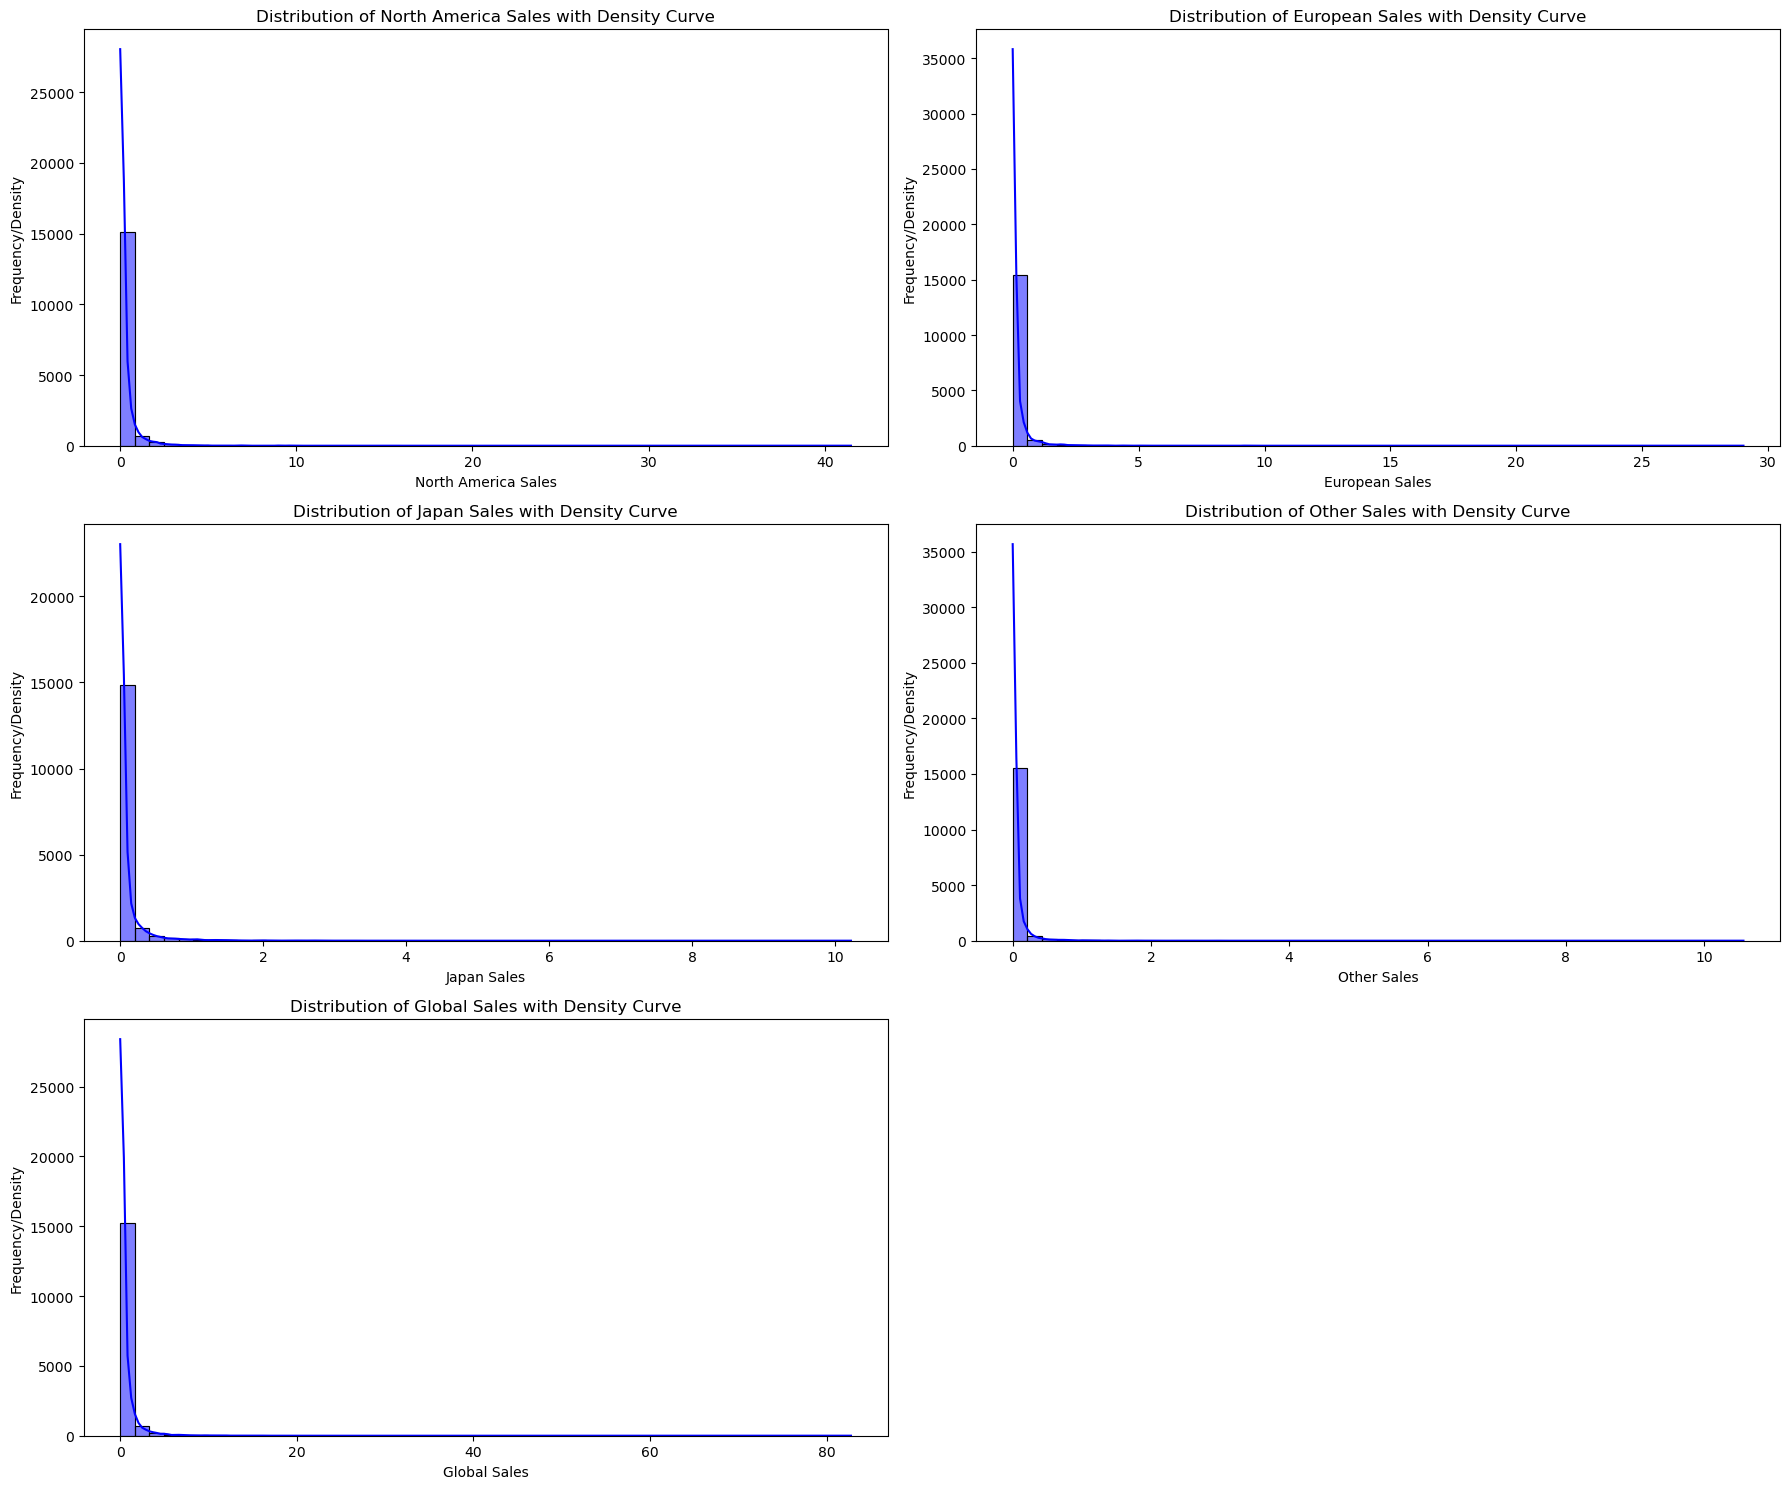

In [129]:
plt.figure(figsize=(18, 15))

for i, column in enumerate(columns, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data[column], bins=50, kde=True, color='blue', edgecolor='black')
    plt.title(f'Distribution of {column} with Density Curve')
    plt.xlabel(column)
    plt.ylabel('Frequency/Density')

plt.tight_layout()
plt.show()


#### Boxplot

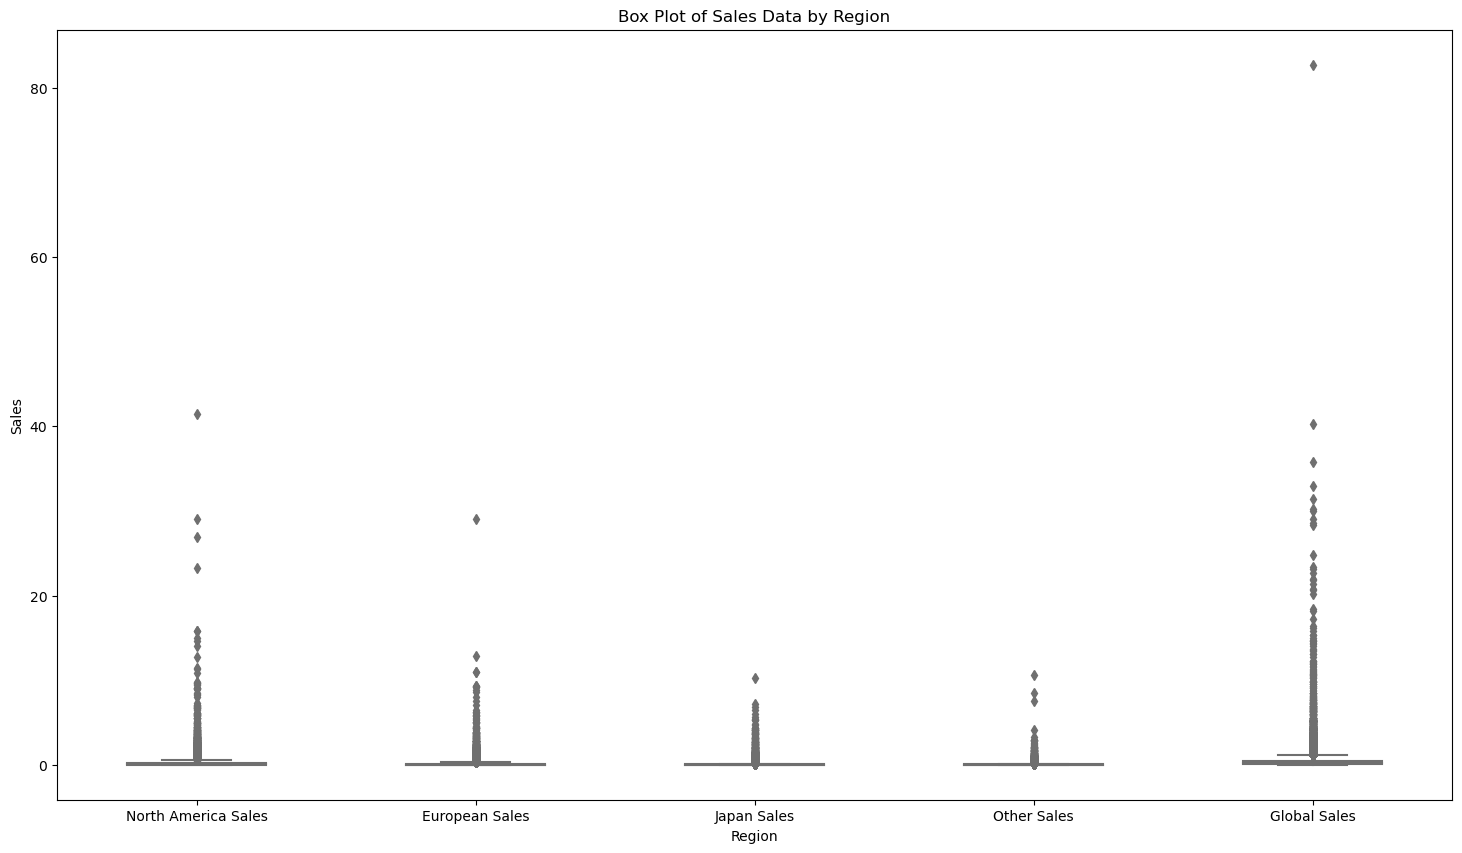

In [130]:
plt.figure(figsize=(18, 10))


sns.boxplot(data=data[columns], width=0.5, palette='pastel')

plt.title('Box Plot of Sales Data by Region')
plt.xlabel('Region')
plt.ylabel('Sales')
plt.show()

#### Quantile Plots

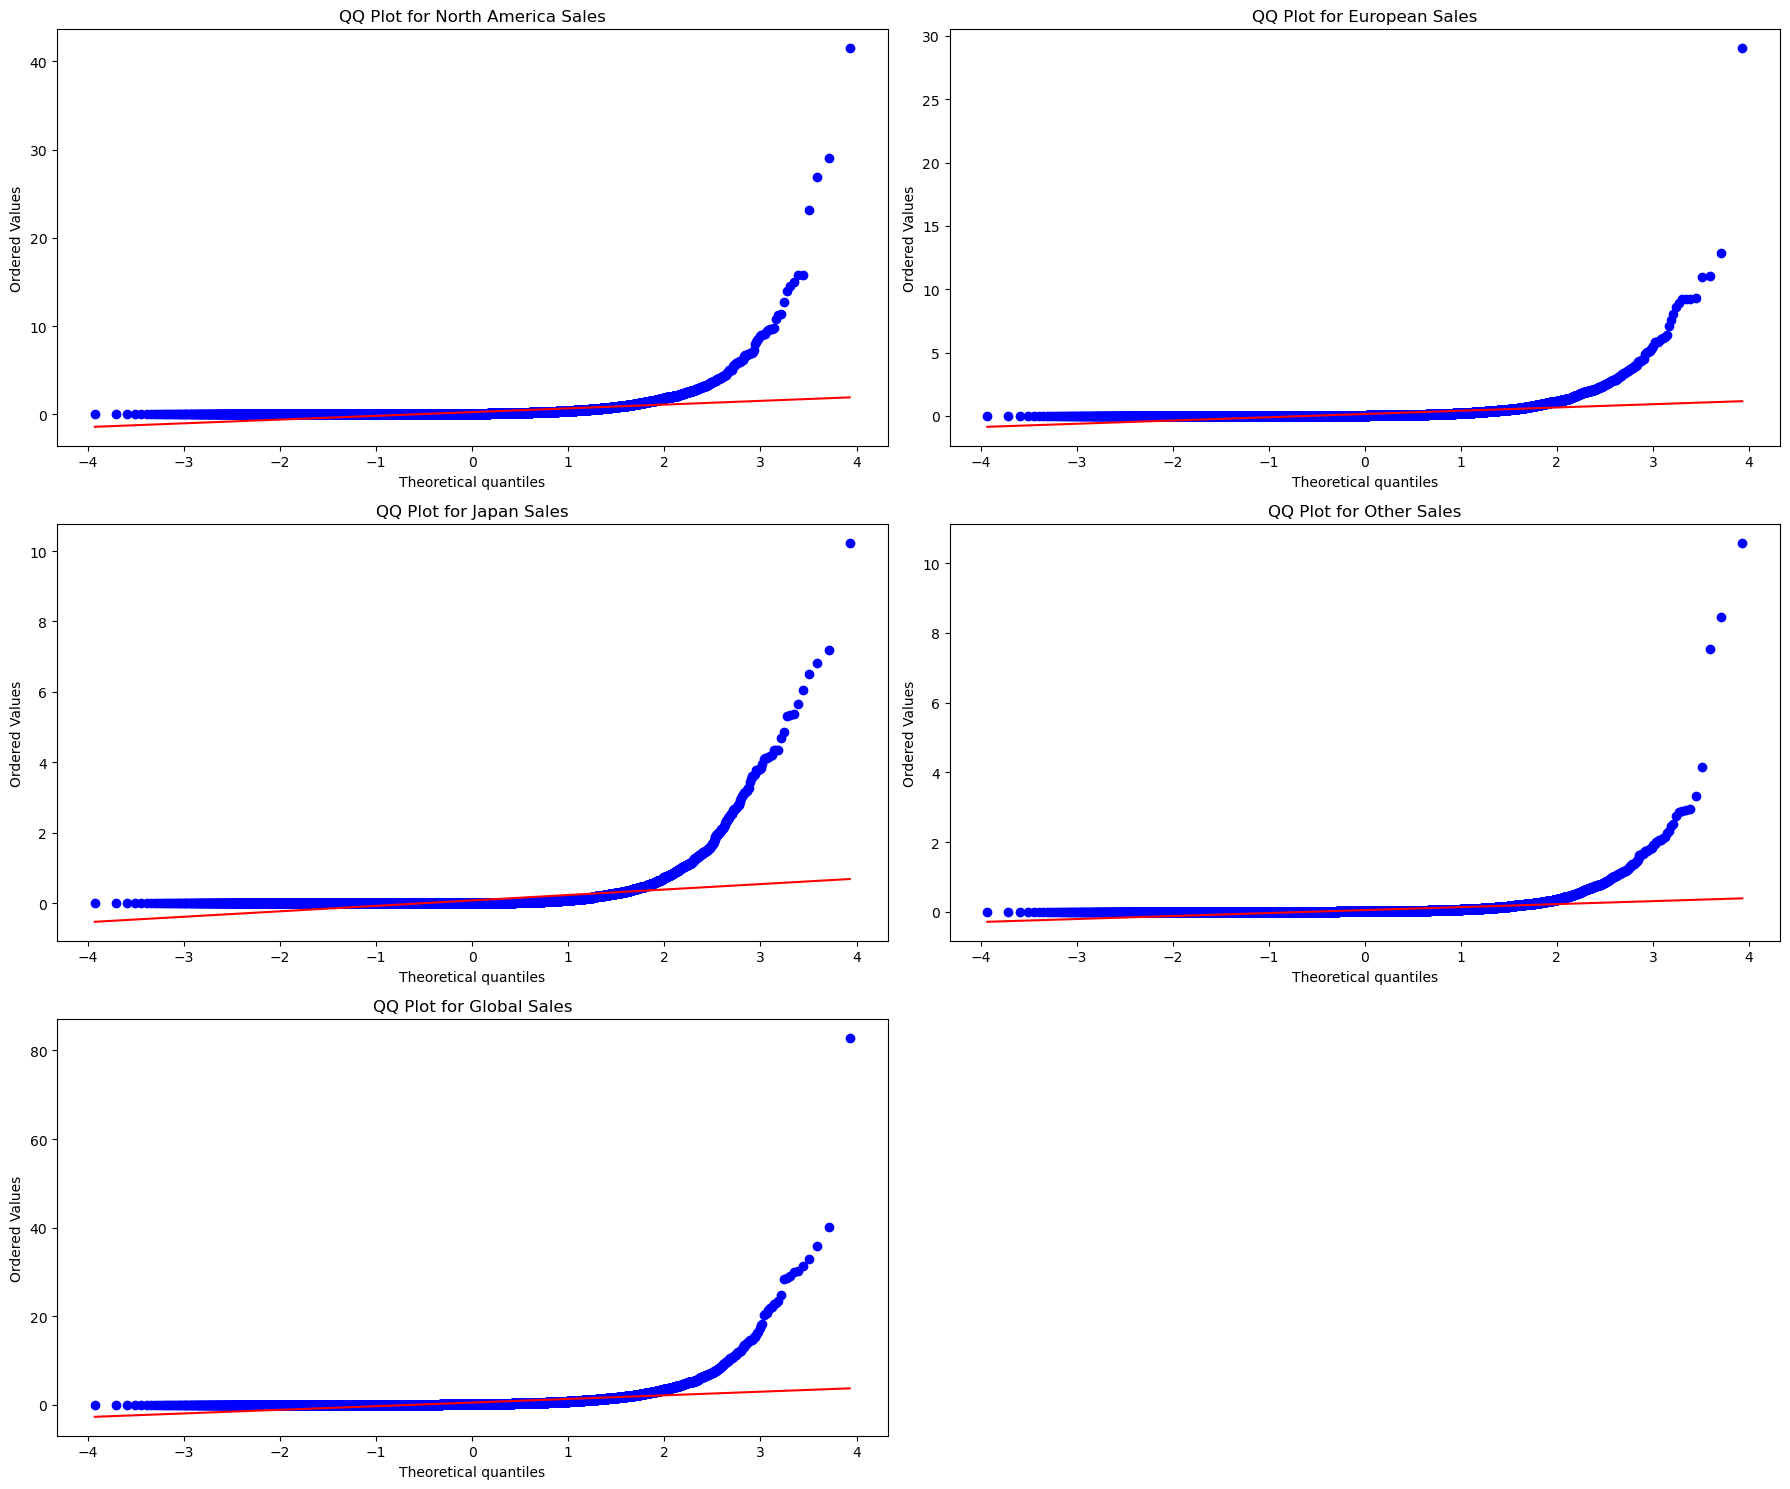

In [131]:
plt.figure(figsize=(18, 15))

for i, column in enumerate(columns, 1):
    plt.subplot(3, 2, i)
    probplot(data[column], plot=plt)
    plt.title(f'QQ Plot for {column}')

plt.tight_layout()
plt.show()

#### Correlation Matrix

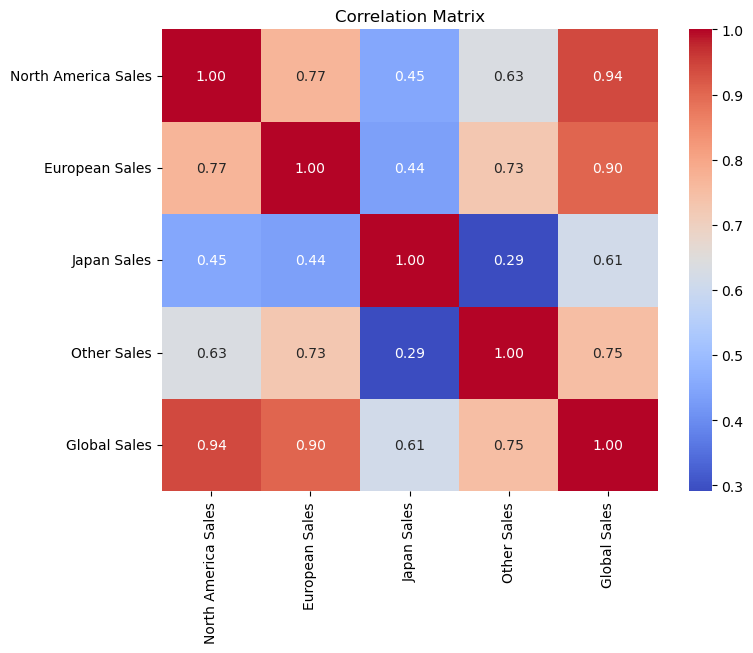

In [132]:
correlation_matrix = data[['North America Sales', 'European Sales', 'Japan Sales', 'Other Sales', 'Global Sales']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


##### Top 5 Best Seller Games

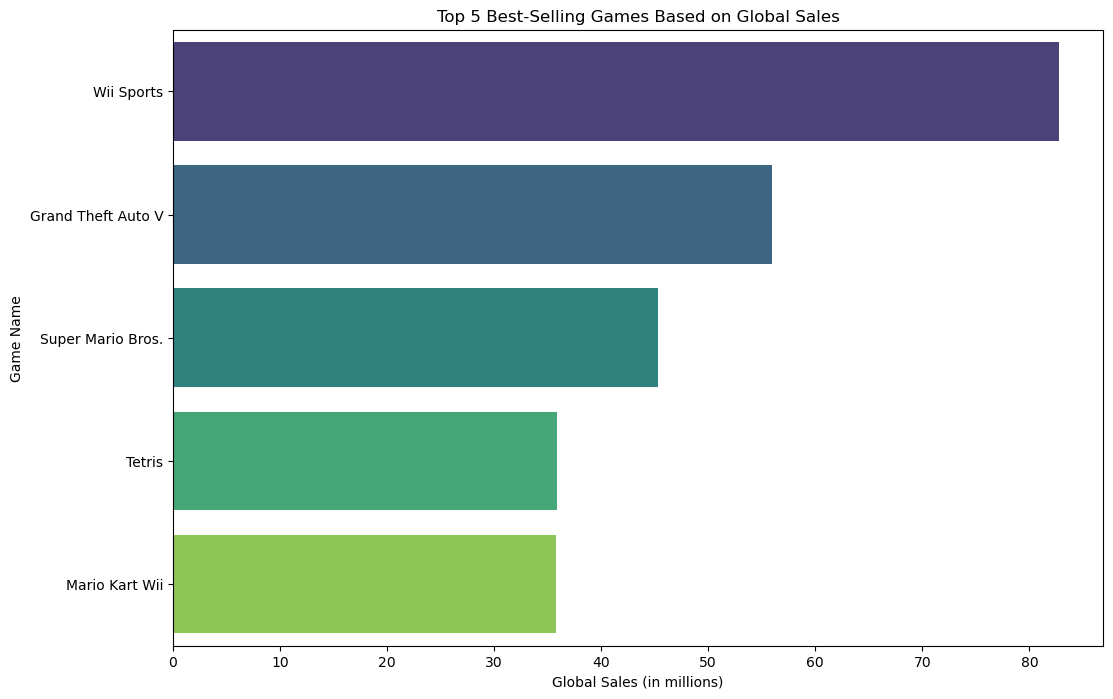

In [133]:
top_sellers_combined = data.groupby('name')['Global Sales'].sum().nlargest(5)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_sellers_combined.values, y=top_sellers_combined.index, palette='viridis')
plt.title('Top 5 Best-Selling Games Based on Global Sales')
plt.xlabel('Global Sales (in millions)')
plt.ylabel('Game Name')
plt.show()


##### Top 5 genres 

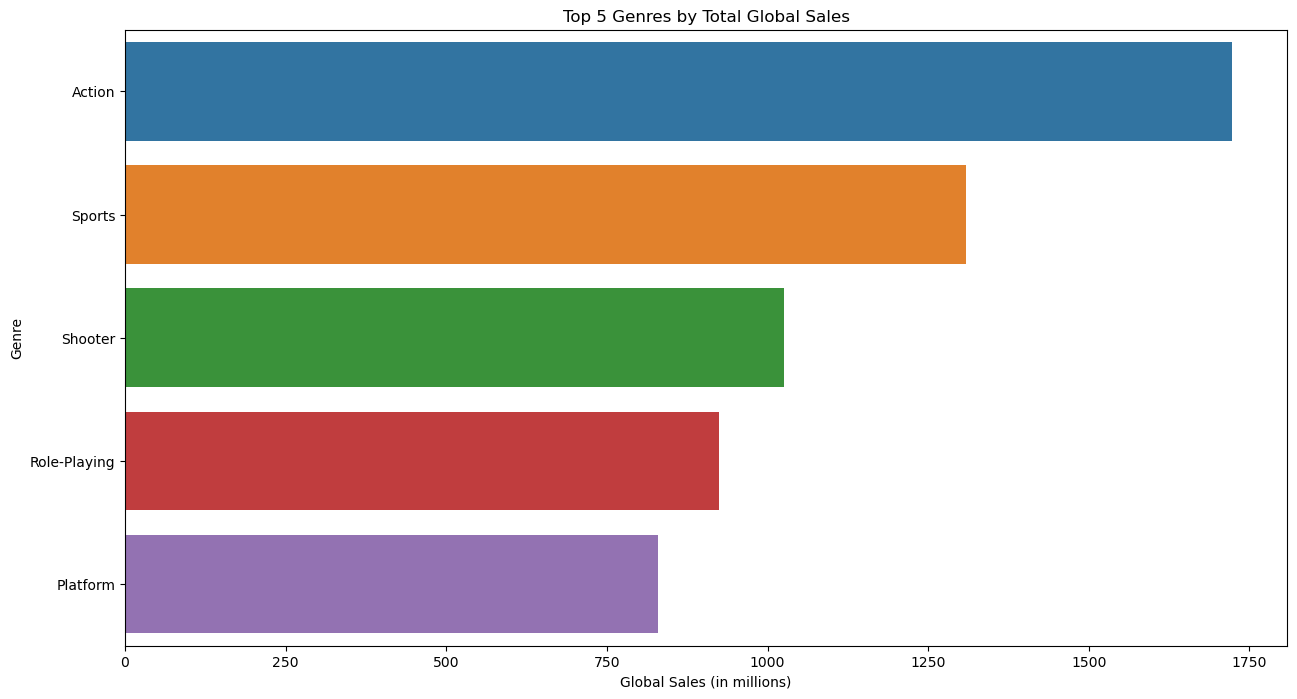

In [134]:
genre_sales = data.groupby('genre')['Global Sales'].sum().nlargest(5)

top_genres = genre_sales.index.tolist()[:5]

plt.figure(figsize=(15, 8))
sns.barplot(x=genre_sales.values, y=genre_sales.index, order=top_genres)
plt.title('Top 5 Genres by Total Global Sales')
plt.xlabel('Global Sales (in millions)')
plt.ylabel('Genre')
plt.show()




##### Top 5 Platforms

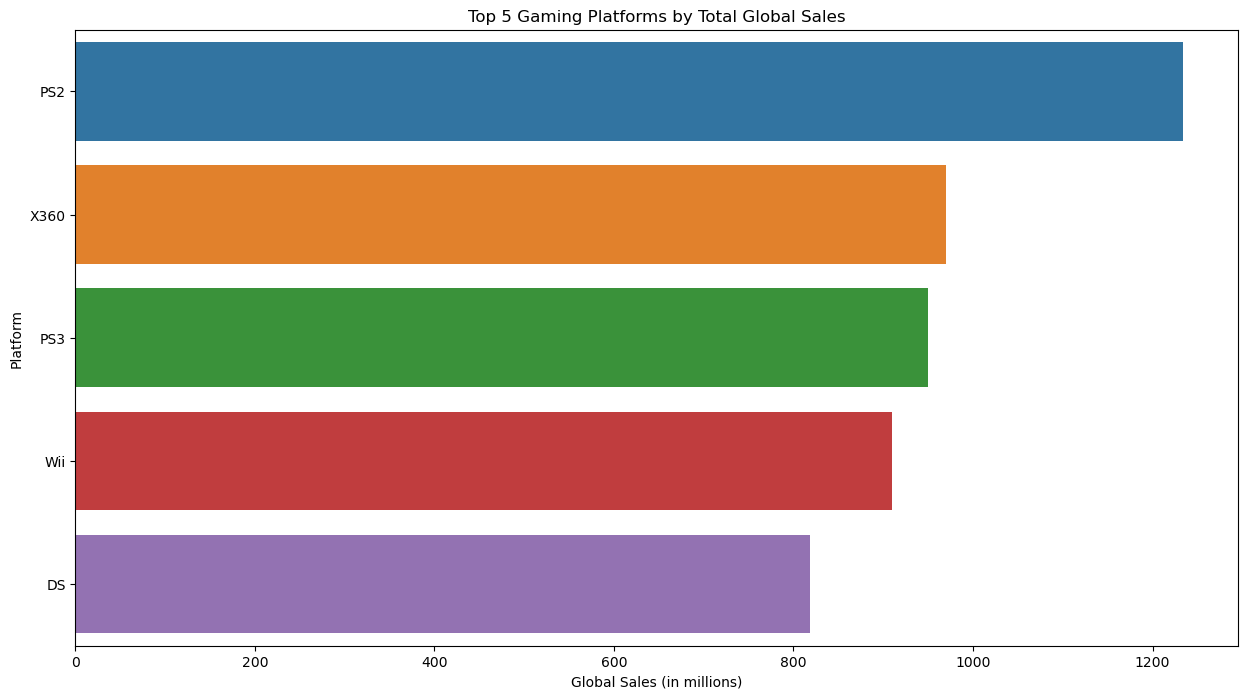

In [135]:
platform_sales = data.groupby('platform')['Global Sales'].sum().nlargest(5)
top_platform = platform_sales.index.tolist()[:5]

plt.figure(figsize=(15, 8))
sns.barplot(x=platform_sales.values, y=top_platform, order=top_platform)
plt.title('Top 5 Gaming Platforms by Total Global Sales')
plt.xlabel('Global Sales (in millions)')
plt.ylabel('Platform')
plt.show()


#### Top 5 publisher


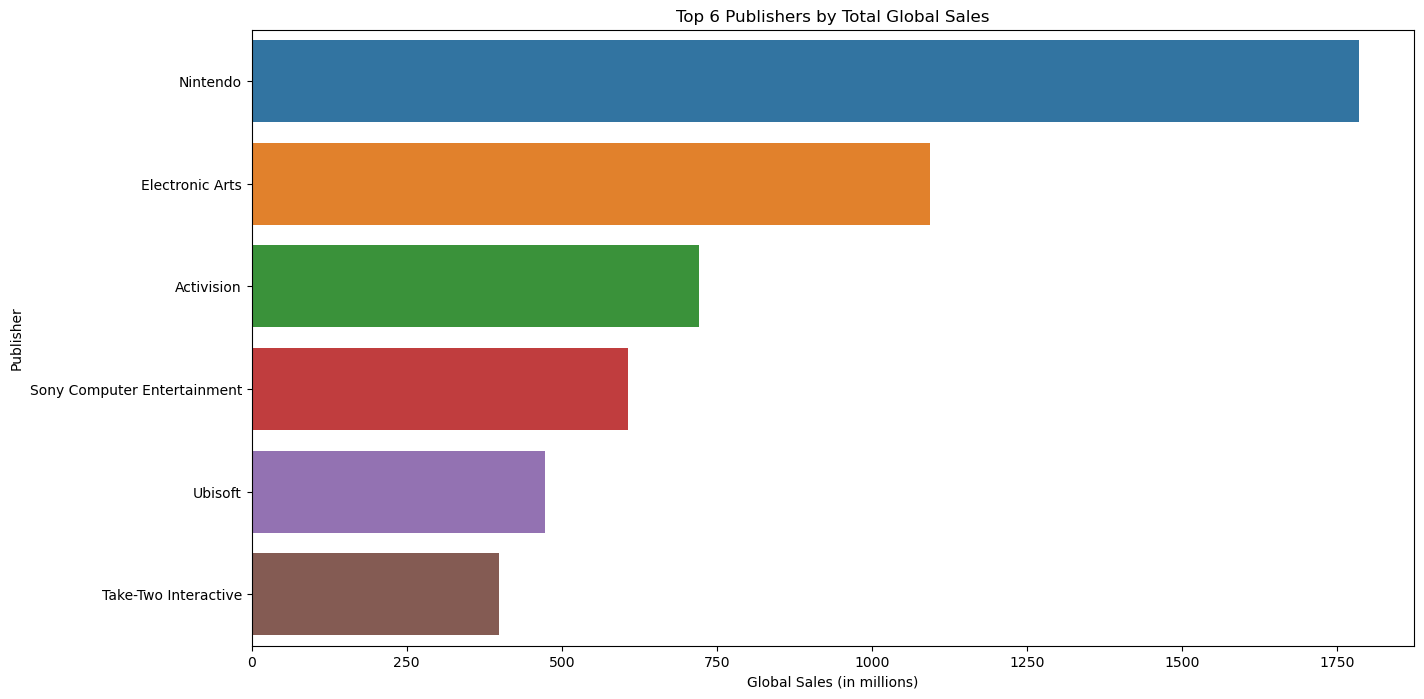

In [136]:
publisher_sales = data.groupby('publisher')['Global Sales'].sum().nlargest(6)
top_publishers = publisher_sales.index.tolist()[:6]

plt.figure(figsize=(15, 8))
sns.barplot(x=publisher_sales.values, y=top_publishers, order=top_publishers)
plt.title('Top 6 Publishers by Total Global Sales')
plt.xlabel('Global Sales (in millions)')
plt.ylabel('Publisher')
plt.show()


#### Sales Distribution by Region

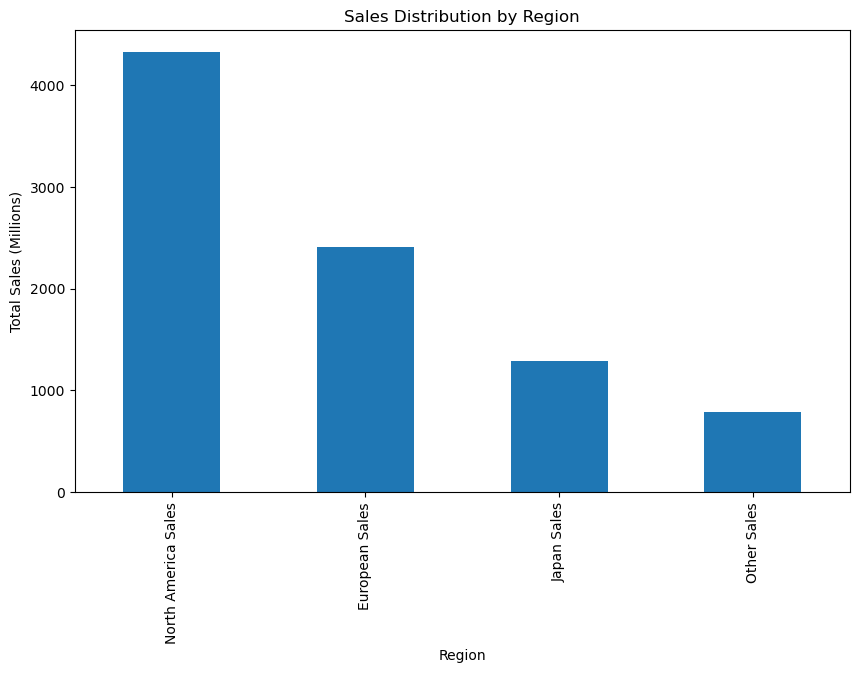

In [137]:
regions = ['North America Sales', 'European Sales', 'Japan Sales', 'Other Sales']

plt.figure(figsize=(10, 6))
data[regions].sum().plot(kind='bar')
plt.title('Sales Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Total Sales (Millions)')
plt.show()

#### Yearly Trends

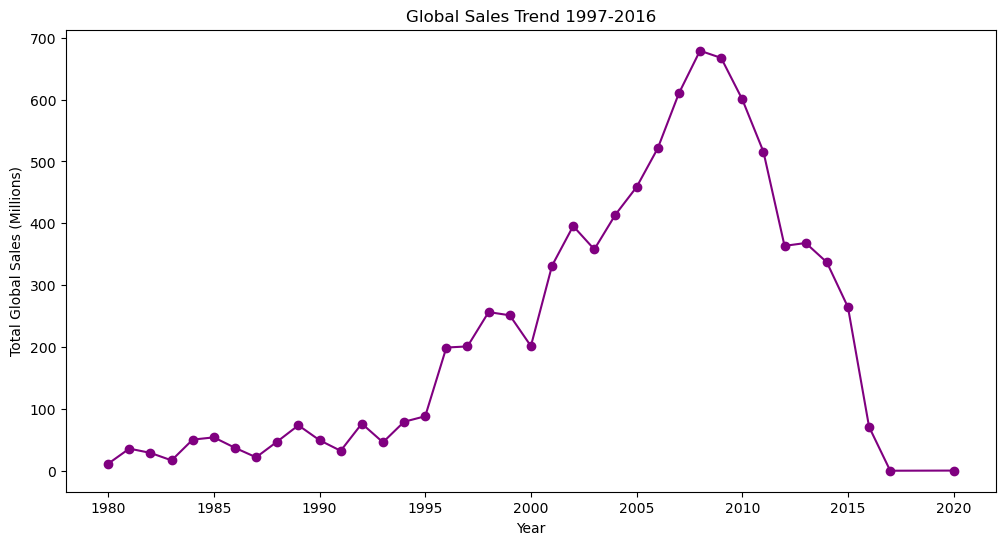

In [138]:
plt.figure(figsize=(12, 6))
data.groupby('year')['Global Sales'].sum().plot(kind='line', marker='o', color='purple')
plt.title('Global Sales Trend 1997-2016')
plt.xlabel('Year')
plt.ylabel('Total Global Sales (Millions)')
plt.show()


#### Genre-Platform Combinations

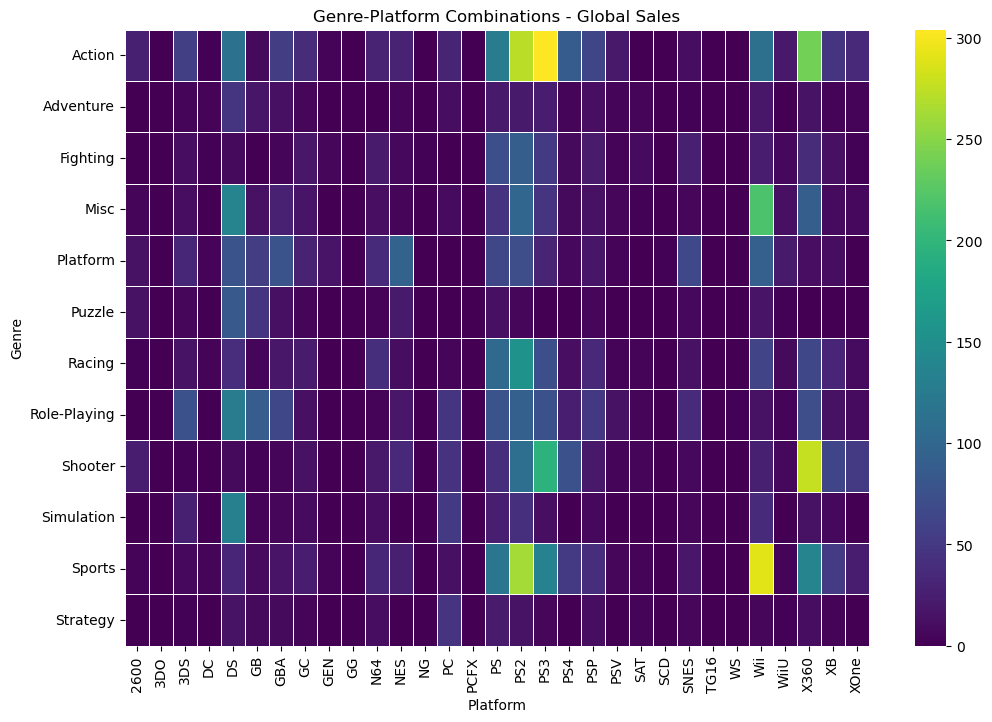

In [139]:
genre_platform_combinations = data.pivot_table(index='genre', columns='platform', values='Global Sales', aggfunc='sum')

plt.figure(figsize=(12, 8))
sns.heatmap(genre_platform_combinations, cmap='viridis', fmt='.1f', linewidths=.5)
plt.title('Genre-Platform Combinations - Global Sales')
plt.xlabel('Platform')
plt.ylabel('Genre')
plt.show()


In [140]:
genre_platform_combinations = data.pivot_table(index='genre', columns='platform', values='Global Sales', aggfunc='sum')

top_combinations = genre_platform_combinations.stack().idxmax()

print("Most Successful Genre-Platform Combinations:")
print(top_combinations)


Most Successful Genre-Platform Combinations:
('Action', 'PS3')


# A/B Testing

#### Platform Impact Hypothesis

In [141]:
platform_1_name = 'PS2'  
platform_2_name = 'X360' 

platform_1_sales = data[data['platform'] == platform_1_name]['Global Sales']
platform_2_sales = data[data['platform'] == platform_2_name]['Global Sales']

t_stat, p_value = stats.ttest_ind(platform_1_sales, platform_2_sales)

alpha = 0.05

if p_value < alpha:
    print(f"Reject the null hypothesis. There is a significant difference in global sales between {platform_1_name} and {platform_2_name}.")
else:
    print(f"Fail to reject the null hypothesis. There is no significant difference in global sales between {platform_1_name} and {platform_2_name}.")


Reject the null hypothesis. There is a significant difference in global sales between PS2 and X360.


#### Genre Impact Hypothesis:

In [142]:
genre_1_name = 'Action'  
genre_2_name = 'Shooter' 

genre_1_sales = data[data['genre'] == genre_1_name]['Global Sales']
genre_2_sales = data[data['genre'] == genre_2_name]['Global Sales']

t_stat_genre, p_value_genre = stats.ttest_ind(genre_1_sales, genre_2_sales)


alpha = 0.05

if p_value_genre < alpha:
    print(f"Reject the null hypothesis. There is a significant difference in global sales between {genre_1_name} and {genre_2_name}.")
else:
    print(f"Fail to reject the null hypothesis. There is no significant difference in global sales between {genre_1_name} and {genre_2_name}.")


Reject the null hypothesis. There is a significant difference in global sales between Action and Shooter.


#### Publisher Impact Hypothesis:

In [143]:
publisher_1_name = 'Take-Two Interactive'  
publisher_2_name = 'Activision'  

publisher_1_sales = data[data['publisher'] == publisher_1_name]['Global Sales']
publisher_2_sales = data[data['publisher'] == publisher_2_name]['Global Sales']

t_stat_publisher, p_value_publisher = stats.ttest_ind(publisher_1_sales, publisher_2_sales)

alpha = 0.05

if p_value_publisher < alpha:
    print(f"Reject the null hypothesis. There is a significant difference in global sales between {publisher_1_name} and {publisher_2_name}.")
else:
    print(f"Fail to reject the null hypothesis. There is no significant difference in global sales between {publisher_1_name} and {publisher_2_name}.")


Reject the null hypothesis. There is a significant difference in global sales between Take-Two Interactive and Activision.


# Model Building

### Fit the model

In [144]:
label_encoder = LabelEncoder()

data['genre_encoded'] = label_encoder.fit_transform(data['genre'])
data['publisher_encoded'] = label_encoder.fit_transform(data['publisher'])
data['platform_encoded'] = label_encoder.fit_transform(data['platform'])

In [145]:
X = data[['genre_encoded', 'publisher_encoded', 'platform_encoded']]

y = data['Global Sales']

In [146]:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           Global Sales   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     9.146
Date:                Tue, 23 Jan 2024   Prob (F-statistic):           4.82e-06
Time:                        16:56:42   Log-Likelihood:                -30423.
No. Observations:               16291   AIC:                         6.085e+04
Df Residuals:                   16287   BIC:                         6.088e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3581      0.03

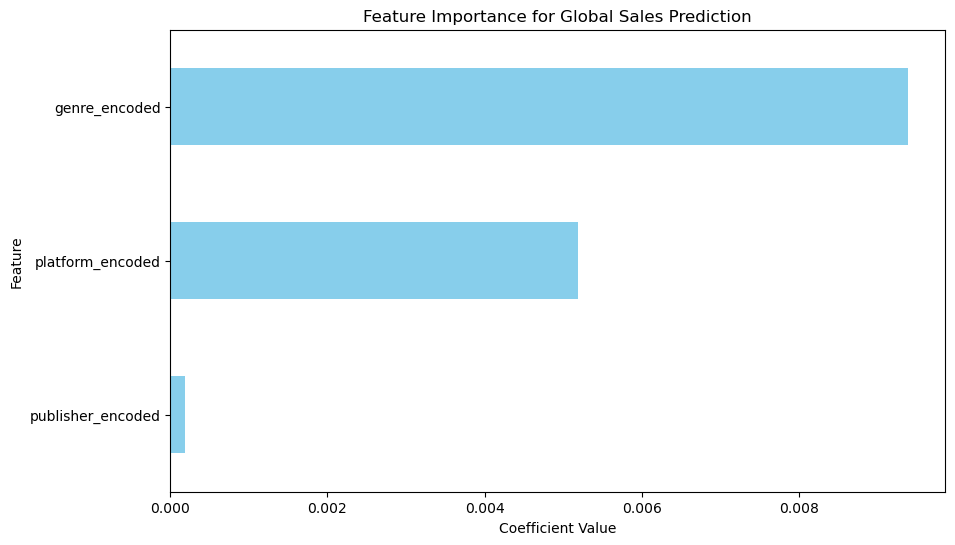

In [147]:
feature_importance = model.params.drop("const")

plt.figure(figsize=(10, 6))
feature_importance.sort_values().plot(kind='barh', color='skyblue')
plt.title('Feature Importance for Global Sales Prediction')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()


### Make Predictions for Global Sales

##### Predictions at Random

In [148]:
genre_range = data['genre_encoded'].max() - data['genre_encoded'].min()
publisher_range = data['publisher_encoded'].max() - data['publisher_encoded'].min()
platform_range = data['platform_encoded'].max() - data['platform_encoded'].min()

random_genre_encoded = np.random.randint(data['genre_encoded'].min(), data['genre_encoded'].min() + genre_range + 1)
random_publisher_encoded = np.random.randint(data['publisher_encoded'].min(), data['publisher_encoded'].min() + publisher_range + 1)
random_platform_encoded = np.random.randint(data['platform_encoded'].min(), data['platform_encoded'].min() + platform_range + 1)

new_random_data = {
    'genre_encoded': random_genre_encoded,
    'publisher_encoded': random_publisher_encoded,
    'platform_encoded': random_platform_encoded,
    'const': 1
}

new_random_data_df = pd.DataFrame([new_random_data])

actual_random_genre = data[data['genre_encoded'] == new_random_data['genre_encoded']]['genre'].iloc[0]
actual_random_publisher = data[data['publisher_encoded'] == new_random_data['publisher_encoded']]['publisher'].iloc[0]
actual_random_platform = data[data['platform_encoded'] == new_random_data['platform_encoded']]['platform'].iloc[0]

print("Actual Random Genre:", actual_random_genre)
print("Actual Random Publisher:", actual_random_publisher)
print("Actual Random Platform:", actual_random_platform)

predicted_random_global_sales = model.predict(new_random_data_df)

print("Predicted Random Global Sales:", predicted_random_global_sales.iloc[0])


Actual Random Genre: Shooter
Actual Random Publisher: Marvelous Entertainment
Actual Random Platform: PS2
Predicted Random Global Sales: 5.6818253263882585


##### Predictons made manually

In [149]:
new_data = {
    'genre_encoded': 10,  
    'publisher_encoded': 359,  
    'platform_encoded': 26,  
    'const': 1  
}

new_data_df = pd.DataFrame([new_data])

# Get the original names for the encoded values
actual_genre = data[data['genre_encoded'] == new_data['genre_encoded']]['genre'].iloc[0]
actual_publisher = data[data['publisher_encoded'] == new_data['publisher_encoded']]['publisher'].iloc[0]
actual_platform = data[data['platform_encoded'] == new_data['platform_encoded']]['platform'].iloc[0]

# Print the actual categories
print("Actual Genre:", actual_genre)
print("Actual Publisher:", actual_publisher)
print("Actual Platform:", actual_platform)

# Make predictions
predicted_global_sales = model.predict(new_data_df)

print("Predicted Global Sales:", predicted_global_sales.iloc[0])


Actual Genre: Sports
Actual Publisher: Nintendo
Actual Platform: Wii
Predicted Global Sales: 6.963548397872952


### Statistical Analysis

#### Test for multicollinearity

- All VIF values are well below 5, which is a good sign. It suggests that there is no severe multicollinearity among the features.

In [150]:
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print(vif_data)



             feature       VIF
0              const  9.231023
1      genre_encoded  1.003293
2  publisher_encoded  1.002902
3   platform_encoded  1.000987


#### Test for heteroskedasticity

- Since the p-value (0.1400) is greater than the typical significance level (e.g., 0.05), we do not have sufficient evidence to reject the null hypothesis.
- This suggests that there is no strong evidence of heteroskedasticity in our model.

In [151]:
# Heteroskedasticity: Breush-Pagan --> Ho: var = constant 

name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(model.resid, model.model.exog)
print(("BP Results:",['bold']))
print(list(zip(name, test)))

('BP Results:', ['bold'])
[('Lagrange multiplier statistic', 5.476703548157174), ('p-value', 0.1400386619168625), ('f-value', 1.8257333842887522), ('f p-value', 0.14005412400102765)]


#### Evaluate the robustness of your coefficient estimates by bootstrapping model

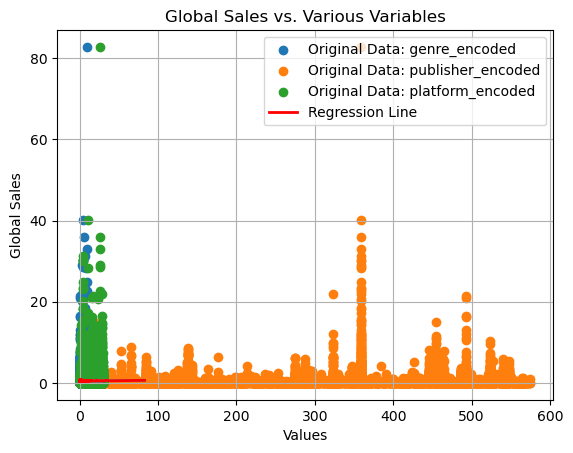

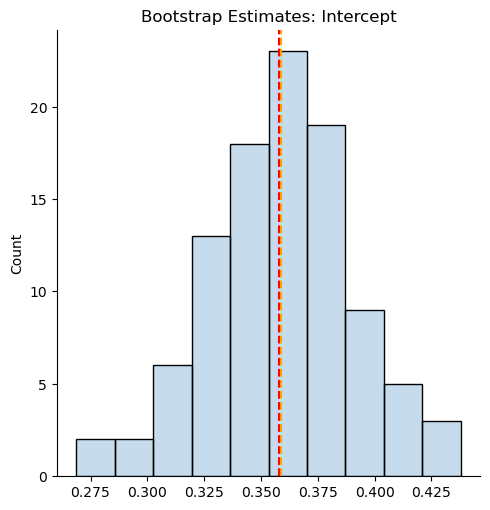

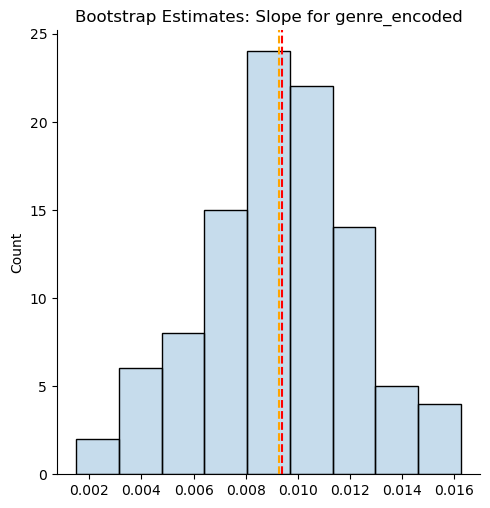

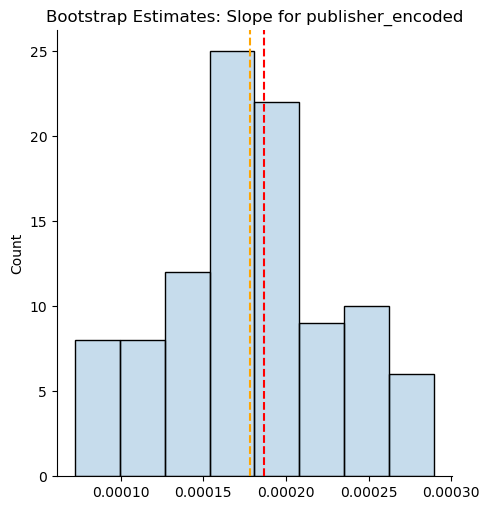

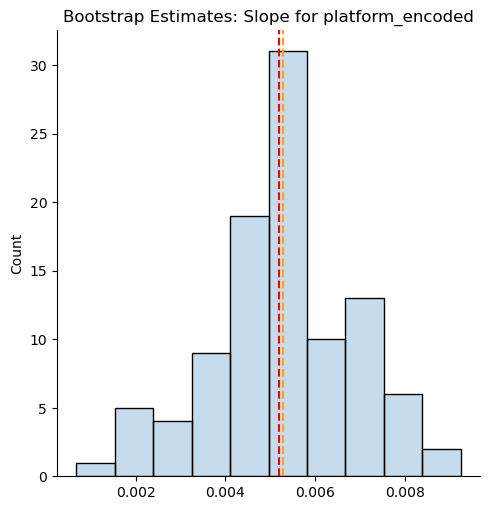

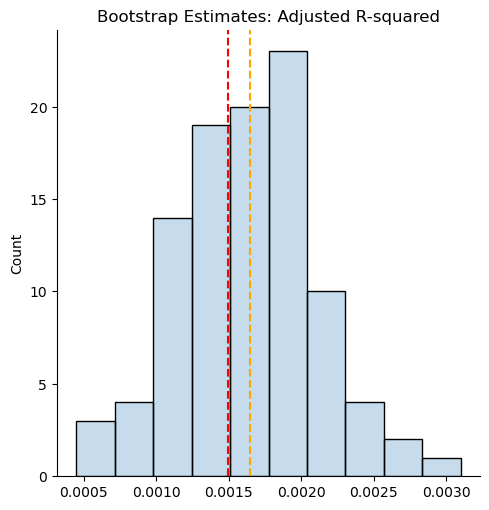

In [152]:
ols_mod = sm.OLS(y, X).fit()

boot_slope_genre = []
boot_slope_publisher = []
boot_slope_platform = []
boot_interc = []
boot_adjR2 = []

n_boots = 100
n_points = data.shape[0]

plt.figure()

for _ in range(n_boots):
    sample_df = data.sample(n=n_points, replace=True)

    X_temp = sm.add_constant(sample_df[['genre_encoded', 'publisher_encoded', 'platform_encoded']])
    y_temp = sample_df['Global Sales']

    ols_model_temp = sm.OLS(y_temp, X_temp).fit()

    boot_interc.append(ols_model_temp.params[0])
    boot_slope_genre.append(ols_model_temp.params[1])
    boot_slope_publisher.append(ols_model_temp.params[2])
    boot_slope_platform.append(ols_model_temp.params[3])
    boot_adjR2.append(ols_model_temp.rsquared_adj)

    y_pred_temp = ols_model_temp.predict(X_temp)
    plt.plot(sample_df['Global Sales'], y_pred_temp, color='grey', alpha=0.2)

y_pred = ols_mod.predict(X)

plt.scatter(data['genre_encoded'], data['Global Sales'], label='Original Data: genre_encoded')
plt.scatter(data['publisher_encoded'], data['Global Sales'], label='Original Data: publisher_encoded')
plt.scatter(data['platform_encoded'], data['Global Sales'], label='Original Data: platform_encoded')

plt.plot(data['Global Sales'], y_pred, linewidth=2, color='red', label='Regression Line')
plt.grid(True)
plt.xlabel('Values')
plt.ylabel('Global Sales')
plt.title('Global Sales vs. Various Variables')
plt.legend()
plt.show()

sns.displot(boot_interc, alpha=0.25)
plt.axvline(x=ols_mod.params[0], color='red', linestyle='--')
plt.axvline(x=np.mean(boot_interc), color='orange', linestyle='--')
plt.title('Bootstrap Estimates: Intercept')
plt.show()

sns.displot(boot_slope_genre, alpha=0.25)
plt.axvline(x=ols_mod.params[1], color='red', linestyle='--')
plt.axvline(x=np.mean(boot_slope_genre), color='orange', linestyle='--')
plt.title('Bootstrap Estimates: Slope for genre_encoded')
plt.show()

sns.displot(boot_slope_publisher, alpha=0.25)
plt.axvline(x=ols_mod.params[2], color='red', linestyle='--')
plt.axvline(x=np.mean(boot_slope_publisher), color='orange', linestyle='--')
plt.title('Bootstrap Estimates: Slope for publisher_encoded')
plt.show()

sns.displot(boot_slope_platform, alpha=0.25)
plt.axvline(x=ols_mod.params[3], color='red', linestyle='--')
plt.axvline(x=np.mean(boot_slope_platform), color='orange', linestyle='--')
plt.title('Bootstrap Estimates: Slope for platform_encoded')
plt.show()

sns.displot(boot_adjR2, alpha=0.25)
plt.axvline(x=ols_mod.rsquared_adj, color='red', linestyle='--')
plt.axvline(x=np.mean(boot_adjR2), color='orange', linestyle='--')
plt.title('Bootstrap Estimates: Adjusted R-squared')
plt.show()


#### Use cross-validation to evaluate your model’s performance

In [153]:
regr = LinearRegression()
model_val = regr.fit(X,y)
regr.coef_
regr.intercept_


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


regr = LinearRegression()
regr.fit(x_train, y_train)


y_pred = regr.predict(x_test)



print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))



regr = linear_model.LinearRegression()
scores = cross_val_score(regr, X, y, cv=5, scoring='neg_root_mean_squared_error')
print('5-Fold CV RMSE Scores:', scores)

MAE: 0.5924579386055017
MSE: 1.9563671461045857
RMSE: 1.398701950418525
5-Fold CV RMSE Scores: [-3.58691194 -0.22708645 -0.47090875 -0.57687974 -0.63498612]
